In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


In [2]:
epochs     = 100
batch_size = 32
window     = 30

# Parameters: Lorenz systems
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
num_steps = 10000
dt = 0.01


# **Create dataset**

In [3]:
# Variables Initialization
x, y, z = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

# Initial conditions
x[0], y[0], z[0] = 0.0, 1.0, 20.0

for i in range(1, num_steps):
    x_dot = sigma * (y[i - 1] - x[i - 1])
    y_dot = x[i - 1] * (rho - z[i - 1]) - y[i - 1]
    z_dot = x[i - 1] * y[i - 1] - beta * z[i - 1]

    x[i] = x[i - 1] + x_dot * dt
    y[i] = y[i - 1] + y_dot * dt
    z[i] = z[i - 1] + z_dot * dt

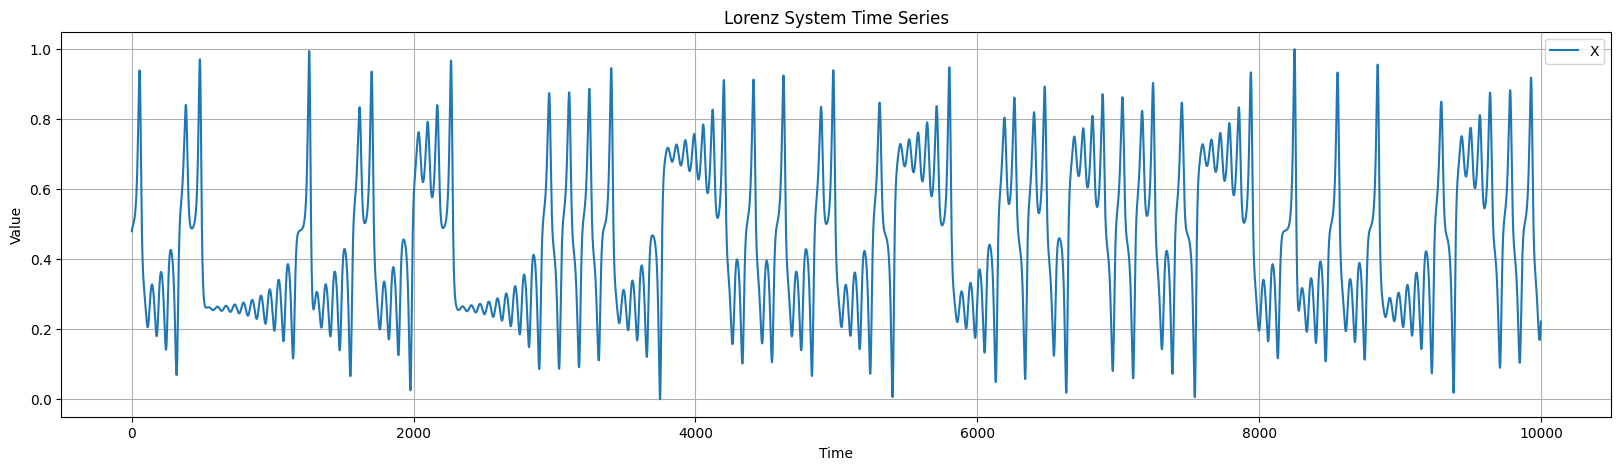

In [4]:
timeserie = x

# Normalization
timeserieNormalized = (timeserie-min(timeserie))/(max(timeserie)-min(timeserie))

plt.figure(figsize=(20, 5))
plt.plot(timeserieNormalized, label='X')
plt.title('Lorenz System Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
X = np.zeros([len(timeserieNormalized)-window, window])
for i in range(len(timeserieNormalized)-window):
  X[i,:] = timeserieNormalized[i:i+window].T
# Vector de salida (pronostico de nuestro modelo)
y = timeserieNormalized[window:]

X = X[:,:, np.newaxis]

X.shape, y.shape

((9970, 30, 1), (9970,))

In [6]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)


# **Custom Layer**

In [7]:
def _get_random_features_initializer(initializer, shape, seed=None):
    # Esta función debe retornar un arreglo numpy con la inicialización deseada.
    # Por ejemplo, si el initializer es 'gaussian':
    if seed is not None:
        np.random.seed(seed)
    if initializer == 'gaussian':
        # Por ejemplo, inicialización gaussiana estándar
        return np.random.randn(*shape)
    elif initializer == 'laplacian':
        # Por ejemplo, inicialización con distribución Laplaciana
        return np.random.laplace(loc=0.0, scale=1.0, size=shape)
    else:
        raise ValueError(f'Unsupported initializer {initializer}')


In [8]:
class Conv1dRFF_PT(nn.Module):
    def __init__(self, output_dim, kernel_size=3, scale=None, padding='VALID', normalization=True,
                 function=True, trainable_scale=False, trainable_W=False, seed=None, kernel='gaussian', **kwargs):
        super(Conv1dRFF_PT, self).__init__()
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.scale = scale
        # Reemplazamos 'VALID' por 0 para no padding
        self.padding = 0 if padding == 'VALID' else padding
        self.normalization = normalization
        self.function = function
        self.trainable_scale = trainable_scale
        self.trainable_W = trainable_W
        self.seed = seed
        self.initializer = kernel

        # Parámetros se inicializarán perezosamente la primera vez que se llame a forward
        self.kernel = None
        self.bias = None
        self.kernel_scale = None

    def forward(self, inputs):
        # Si los parámetros no están inicializados, los inicializamos ahora
        if self.kernel is None:
            input_shape = inputs.shape
            input_dim = input_shape[1]

            kernel_initializer = _get_random_features_initializer(
                self.initializer,
                shape=(self.output_dim, input_dim, self.kernel_size),
                seed=self.seed
            )

            self.kernel = nn.Parameter(torch.tensor(kernel_initializer, dtype=torch.float32),
                                       requires_grad=self.trainable_W)

            self.bias = nn.Parameter(torch.empty(self.output_dim).uniform_(0.0, 2 * np.pi),
                                     requires_grad=self.trainable_W)

            # Set scale if not provided
            if self.scale is None:
                if self.initializer == 'gaussian':
                    self.scale = np.sqrt((input_dim * (self.kernel_size ** 2)) / 2.0)
                elif self.initializer == 'laplacian':
                    self.scale = 1.0
                else:
                    raise ValueError(f'Unsupported kernel initializer {self.initializer}')

            self.kernel_scale = nn.Parameter(torch.tensor([self.scale], dtype=torch.float32),
                                             requires_grad=self.trainable_scale)

        scale = 1.0 / self.kernel_scale
        kernel = scale * self.kernel

        outputs = F.conv1d(inputs, kernel, bias=self.bias, stride=1, padding=self.padding)

        #Si normalization es True:
        if self.normalization:
            # Crear el factor de escala sqrt(2 / output_dim)
            scale_factor = torch.sqrt(torch.tensor(2.0 / self.output_dim, dtype=outputs.dtype, device=outputs.device))

            if self.function:
                # outputs = scale_factor * cos(outputs)
                outputs = scale_factor * torch.cos(outputs)
            else:
                # condition = (outputs % 2 == 0)
                condition = (outputs % 2 == 0)
                # outputs = where(condition, scale_factor * cos(outputs), scale_factor * sin(outputs))
                outputs = torch.where(condition,
                                      scale_factor * torch.cos(outputs),
                                      scale_factor * torch.sin(outputs))
        else:
            # Si normalization es False
            if self.function:
                # outputs = cos(outputs)
                outputs = torch.cos(outputs)
            else:
                # condition = (outputs % 2 == 0)
                condition = (outputs % 2 == 0)
                # outputs = where(condition, cos(outputs), sin(outputs))
                outputs = torch.where(condition, torch.cos(outputs), torch.sin(outputs))

        return outputs



# **Dataset**

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((6380, 30, 1), (6380,), (1596, 30, 1), (1596,), (1994, 30, 1), (1994,))

In [10]:
X_train_t = torch.tensor(X_train.transpose(0, 2, 1), dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_valid_t = torch.tensor(X_valid.transpose(0, 2, 1), dtype=torch.float32)
y_valid_t = torch.tensor(y_valid.reshape(-1, 1), dtype=torch.float32)
X_test_t  = torch.tensor(X_test.transpose(0, 2, 1), dtype=torch.float32)
y_test_t  = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

X_train_t.shape, y_train_t.shape, X_valid_t.shape, y_valid_t.shape, X_test_t.shape, y_test_t.shape

(torch.Size([6380, 1, 30]),
 torch.Size([6380, 1]),
 torch.Size([1596, 1, 30]),
 torch.Size([1596, 1]),
 torch.Size([1994, 1, 30]),
 torch.Size([1994, 1]))

# **Model**

## Simple

In [11]:
class ForecastModel(nn.Module):
    def __init__(self, output_dim=100, kernel_size=5, horizon=1):
        super(ForecastModel, self).__init__()
        self.conv_rff = Conv1dRFF_PT(output_dim=output_dim, kernel_size=kernel_size,
                                     seed=42, kernel='gaussian', padding='VALID',
                                     normalization=True, function=True)
        # Calcular la dimensión de salida tras la conv:
        # length_out = input_window - kernel_size + 1 = 30 - 5 + 1 = 26 (con padding=0, stride=1)
        self.flatten = nn.Flatten()
        # La capa lineal final para predecir horizon=1 valor
        self.fc = nn.Linear(output_dim*26, horizon)

    def forward(self, x):
        x = self.conv_rff(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [12]:
model_simple = ForecastModel(output_dim=100, kernel_size=5, horizon=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_simple.parameters(), lr=1e-4, weight_decay=1e-5)

In [13]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    model_simple.train()
    permutation = np.random.permutation(len(X_train_t))
    epoch_train_loss = 0.0

    for i in range(0, len(X_train_t), batch_size):
        idx = permutation[i:i+batch_size]
        X_batch = X_train_t[idx]
        Y_batch = y_train_t[idx]

        optimizer.zero_grad()
        pred = model_simple(X_batch)
        loss = criterion(pred, Y_batch)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()*len(X_batch)

    epoch_train_loss /= len(X_train_t)

    # Validación
    model_simple.eval()
    with torch.no_grad():
        pred_val = model_simple(X_valid_t)
        val_loss = criterion(pred_val, y_valid_t).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 10/100, Train Loss: 0.0028, Val Loss: 0.0025
Epoch 20/100, Train Loss: 0.0011, Val Loss: 0.0009
Epoch 30/100, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 40/100, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 50/100, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 60/100, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 70/100, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 80/100, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 90/100, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 100/100, Train Loss: 0.0001, Val Loss: 0.0001


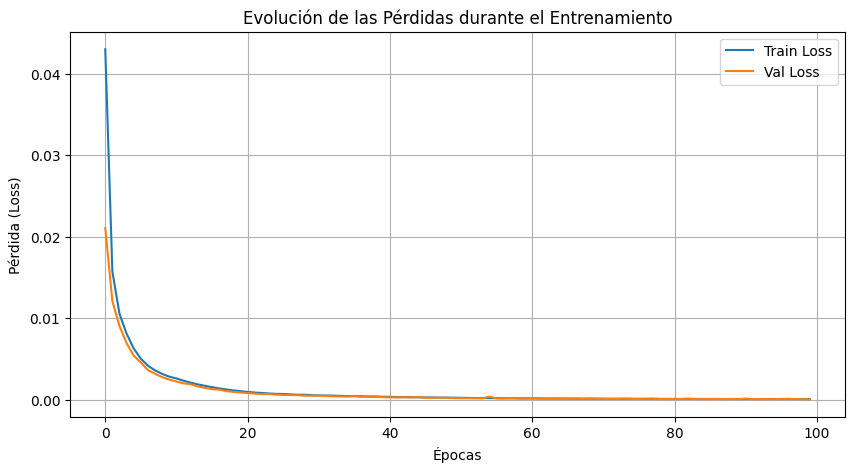

In [14]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Evolución de las Pérdidas durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.grid(True)
plt.legend()
plt.show()

In [15]:
model_simple.eval()
with torch.no_grad():
    pred_test = model_simple(X_test_t)

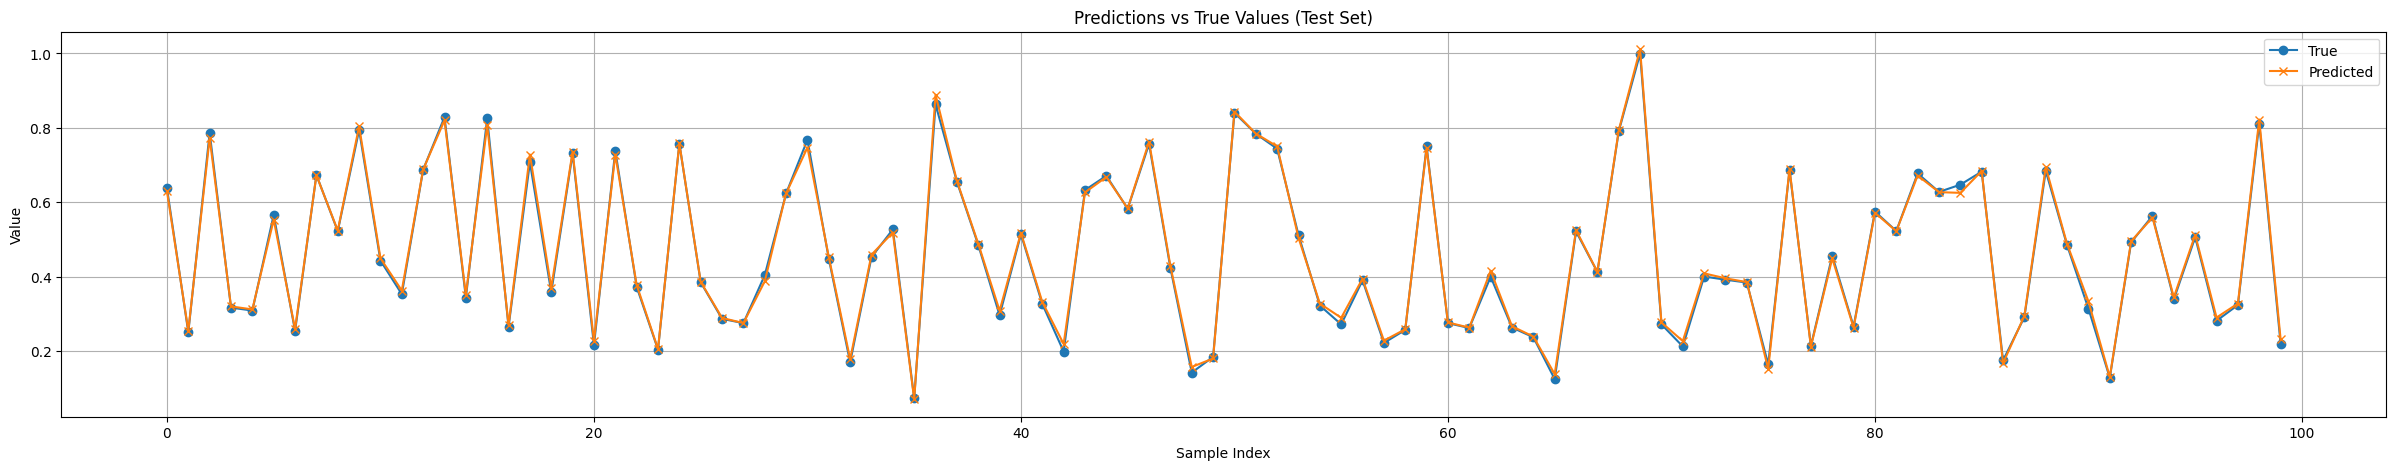

In [16]:
true_values = y_test_t.detach().numpy()
pred_values = pred_test.detach().numpy()

plt.figure(figsize=(30,5))
plt.plot(true_values[0:100], label='True', marker='o')
plt.plot(pred_values[0:100], label='Predicted', marker='x')
plt.title('Predictions vs True Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

## LSTM

In [17]:
class ForecastModel_LSTM(nn.Module):
    def __init__(self, output_dim=100, kernel_size=5, horizon=1, lstm_hidden_size=64, lstm_num_layers=1):
        super(ForecastModel_LSTM, self).__init__()


        self.conv_rff = Conv1dRFF_PT(output_dim=output_dim, kernel_size=kernel_size,
                                     seed=42, kernel='gaussian', padding='VALID', normalization=True, function=True
        )

        # Para una entrada de longitud 30 y kernel_size=5,
        # con padding=0 (VALID) y stride=1,
        # la salida de conv1d tiene longitud: 30 - 5 + 1 = 26
        self.length_out = 30 - kernel_size + 1  # 26

        # 2. Definimos la LSTM
        #   - input_size = output_dim (la dimensión de los "features" tras la conv)
        #   - hidden_size = lstm_hidden_size
        #   - num_layers = lstm_num_layers
        #   - batch_first=True para que la entrada sea (batch, seq_len, features)
        self.lstm = nn.LSTM(input_size=output_dim, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, batch_first=True)

        # 3. Capa lineal para predecir horizon=1
        #    Como tomaremos la última salida de la LSTM, su dimensión es lstm_hidden_size
        self.fc = nn.Linear(lstm_hidden_size, horizon)

    def forward(self, x):
        """
        Parámetro x: tensor de forma (batch_size, 1, 30)
        """
        # ----- Paso 1: Convolución RFF -----
        # Salida de forma: (batch_size, output_dim, length_out=26)
        x = self.conv_rff(x)

        # ----- Paso 2: Reordenar para LSTM -----
        # LSTM espera (batch_size, seq_len, input_size).
        # Ahora x.shape = (batch_size, output_dim, 26).
        # Queremos que '26' sea seq_len, y 'output_dim' sea input_size:
        x = x.permute(0, 2, 1)  # -> (batch_size, 26, output_dim)

        # ----- Paso 3: LSTM -----
        # out_lstm tiene forma (batch_size, seq_len=26, lstm_hidden_size).
        # h, c son los estados ocultos y de celda finales (cada uno de forma (num_layers, batch_size, hidden_size)).
        out_lstm, (h, c) = self.lstm(x)

        # Si solo necesitamos la última salida temporal para predecir:
        # Podemos tomar out_lstm[:, -1, :] => (batch_size, lstm_hidden_size)
        x = out_lstm[:, -1, :]

        # ----- Paso 4: Capa fully-connected final -----
        # x.shape = (batch_size, lstm_hidden_size)
        x = self.fc(x)  # -> (batch_size, horizon)

        return x

In [18]:
model_LSTM = ForecastModel_LSTM(output_dim=100, kernel_size=5, horizon=1, lstm_hidden_size=64, lstm_num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=1e-4, weight_decay=1e-5)

In [19]:
train_losses = []
val_losses = []

# Para asegurarnos de reproducibilidad:
torch.manual_seed(42)
np.random.seed(42)

for epoch in range(epochs):

    model_LSTM.train()

    # Mezclamos (aleatoriamente) los índices de entrenamiento
    permutation = np.random.permutation(len(X_train_t))
    epoch_train_loss = 0.0

    for i in range(0, len(X_train_t), batch_size):
        idx = permutation[i:i+batch_size]
        X_batch = X_train_t[idx]  # (batch, 1, 30)
        Y_batch = y_train_t[idx]  # (batch, 1)  -> MSELoss ok

        # Aseguramos los gradientes en cero
        optimizer.zero_grad()

        # Forward
        pred = model_LSTM(X_batch)

        # Cálculo de la pérdida
        loss = criterion(pred, Y_batch)

        # Backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Acumulamos pérdida
        epoch_train_loss += loss.item() * len(X_batch)

    # Promedio de pérdida en el epoch
    epoch_train_loss /= len(X_train_t)

    # --- Modo evaluación (validación) ---
    model_LSTM.eval()
    with torch.no_grad():
        pred_val = model_LSTM(X_valid_t)
        val_loss = criterion(pred_val, y_valid_t).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    # Imprimimos cada 10 epoch, por ejemplo
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}")


Epoch 10/100, Train Loss: 0.0010, Val Loss: 0.0009
Epoch 20/100, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 30/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 40/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 50/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 60/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 70/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 80/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 90/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 100/100, Train Loss: 0.0000, Val Loss: 0.0000


In [20]:
model_LSTM.eval()
with torch.no_grad():
    pred_test = model_LSTM(X_test_t)

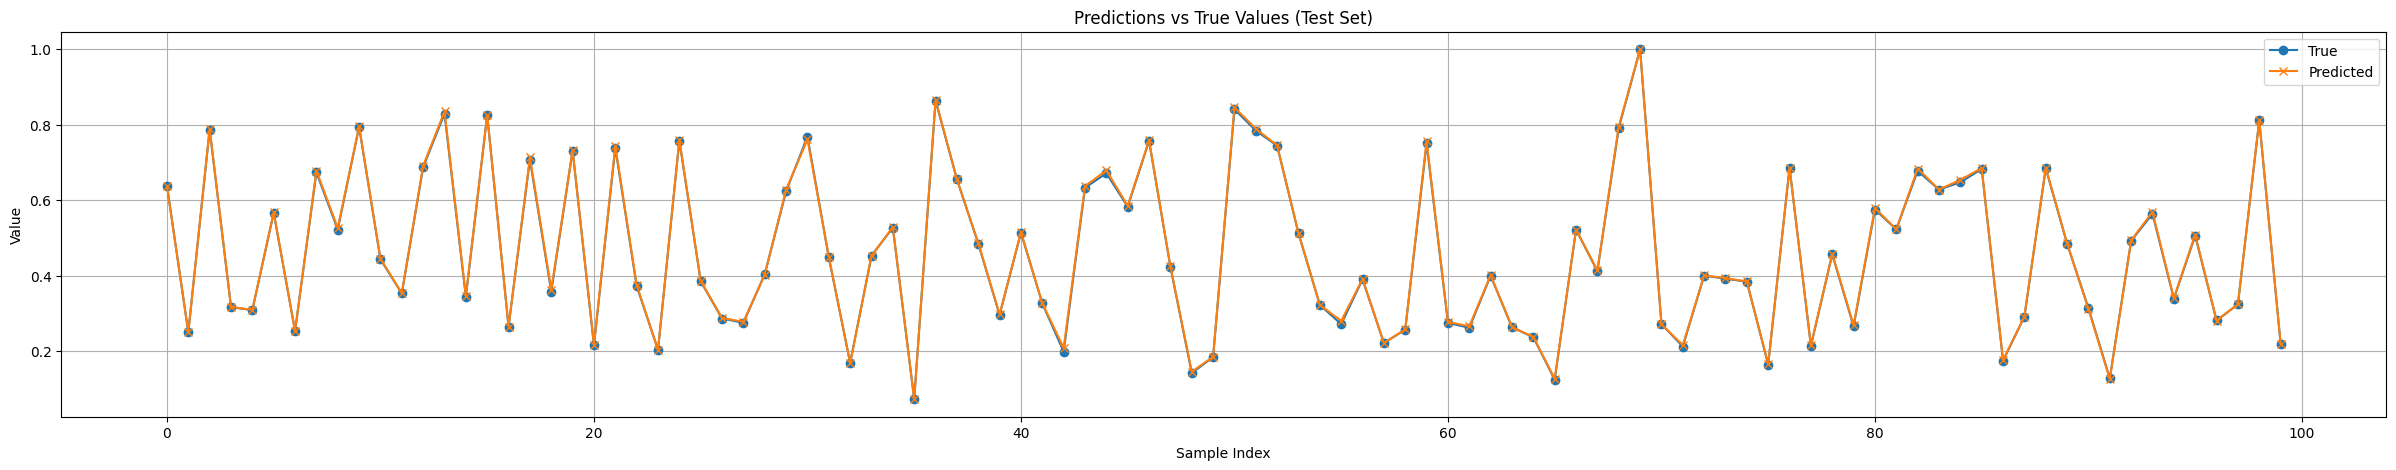

In [21]:
true_values = y_test_t.detach().numpy()
pred_values = pred_test.detach().numpy()

plt.figure(figsize=(30,5))
plt.plot(true_values[0:100], label='True', marker='o')
plt.plot(pred_values[0:100], label='Predicted', marker='x')
plt.title('Predictions vs True Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

## GRU

In [22]:
class ForecastModel_GRU(nn.Module):
    def __init__(self, output_dim=100, kernel_size=5, horizon=1,
                 lstm_hidden_size=64, lstm_num_layers=1):
        super(ForecastModel_GRU, self).__init__()

        self.conv_rff = Conv1dRFF_PT(
            output_dim=output_dim,
            kernel_size=kernel_size,
            seed=42,
            kernel='gaussian',
            padding='VALID',
            normalization=True,
            function=True
        )

        # Para una entrada de longitud 30 y kernel_size=5,
        # con padding=0 (VALID) y stride=1,
        # la salida de conv1d tendrá longitud 26 = (30 - 5 + 1)
        self.length_out = 30 - kernel_size + 1  # 26

        # 2. Definimos la GRU en lugar de la LSTM
        #    - input_size = output_dim (la dimensión de los "features" tras la conv)
        #    - hidden_size = lstm_hidden_size
        #    - num_layers = lstm_num_layers
        #    - batch_first=True => (batch_size, seq_len, features)
        self.gru = nn.GRU(
            input_size=output_dim,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True
        )

        # 3. Capa lineal final para predecir horizon=1
        self.fc = nn.Linear(lstm_hidden_size, horizon)

    def forward(self, x):
        """
        x: tensor de forma (batch_size, 1, 30)
        """
        # ----- Paso 1: Convolución RFF -----
        # Sale con forma (batch_size, output_dim, length_out=26)
        x = self.conv_rff(x)

        # ----- Paso 2: Permutamos para la GRU -----
        # GRU con batch_first=True => (batch_size, seq_len, input_size)
        # seq_len = 26, input_size = output_dim
        x = x.permute(0, 2, 1)  # (batch_size, 26, output_dim)

        # ----- Paso 3: GRU -----
        # out_gru => (batch_size, seq_len=26, lstm_hidden_size)
        # h => (num_layers, batch_size, lstm_hidden_size)
        out_gru, h = self.gru(x)

        # Tomamos la salida del último paso temporal
        x = out_gru[:, -1, :]  # (batch_size, lstm_hidden_size)

        # ----- Paso 4: Capa fully-connected final -----
        # x.shape = (batch_size, lstm_hidden_size)
        x = self.fc(x)  # -> (batch_size, horizon)

        return x


In [23]:
model_GRU = ForecastModel_GRU(output_dim=100, kernel_size=5, horizon=1, lstm_hidden_size=64, lstm_num_layers=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=1e-4, weight_decay=1e-5)

In [24]:
train_losses = []
val_losses = []

# Para asegurarnos de reproducibilidad:
torch.manual_seed(42)
np.random.seed(42)

for epoch in range(epochs):

    model_GRU.train()

    # Mezclamos (aleatoriamente) los índices de entrenamiento
    permutation = np.random.permutation(len(X_train_t))
    epoch_train_loss = 0.0

    for i in range(0, len(X_train_t), batch_size):
        idx = permutation[i:i+batch_size]
        X_batch = X_train_t[idx]  # (batch, 1, 30)
        Y_batch = y_train_t[idx]  # (batch, 1)  -> MSELoss ok

        # Aseguramos los gradientes en cero
        optimizer.zero_grad()

        # Forward
        pred = model_GRU(X_batch)

        # Cálculo de la pérdida
        loss = criterion(pred, Y_batch)

        # Backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Acumulamos pérdida
        epoch_train_loss += loss.item() * len(X_batch)

    # Promedio de pérdida en el epoch
    epoch_train_loss /= len(X_train_t)

    # --- Modo evaluación (validación) ---
    model_GRU.eval()
    with torch.no_grad():
        pred_val = model_GRU(X_valid_t)
        val_loss = criterion(pred_val, y_valid_t).item()

    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)

    # Imprimimos cada 10 epoch, por ejemplo
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}")

Epoch 10/100, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 20/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 30/100, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 40/100, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 50/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 60/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 70/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 80/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 90/100, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 100/100, Train Loss: 0.0000, Val Loss: 0.0000


In [25]:
model_GRU.eval()
with torch.no_grad():
    pred_test = model_GRU(X_test_t)

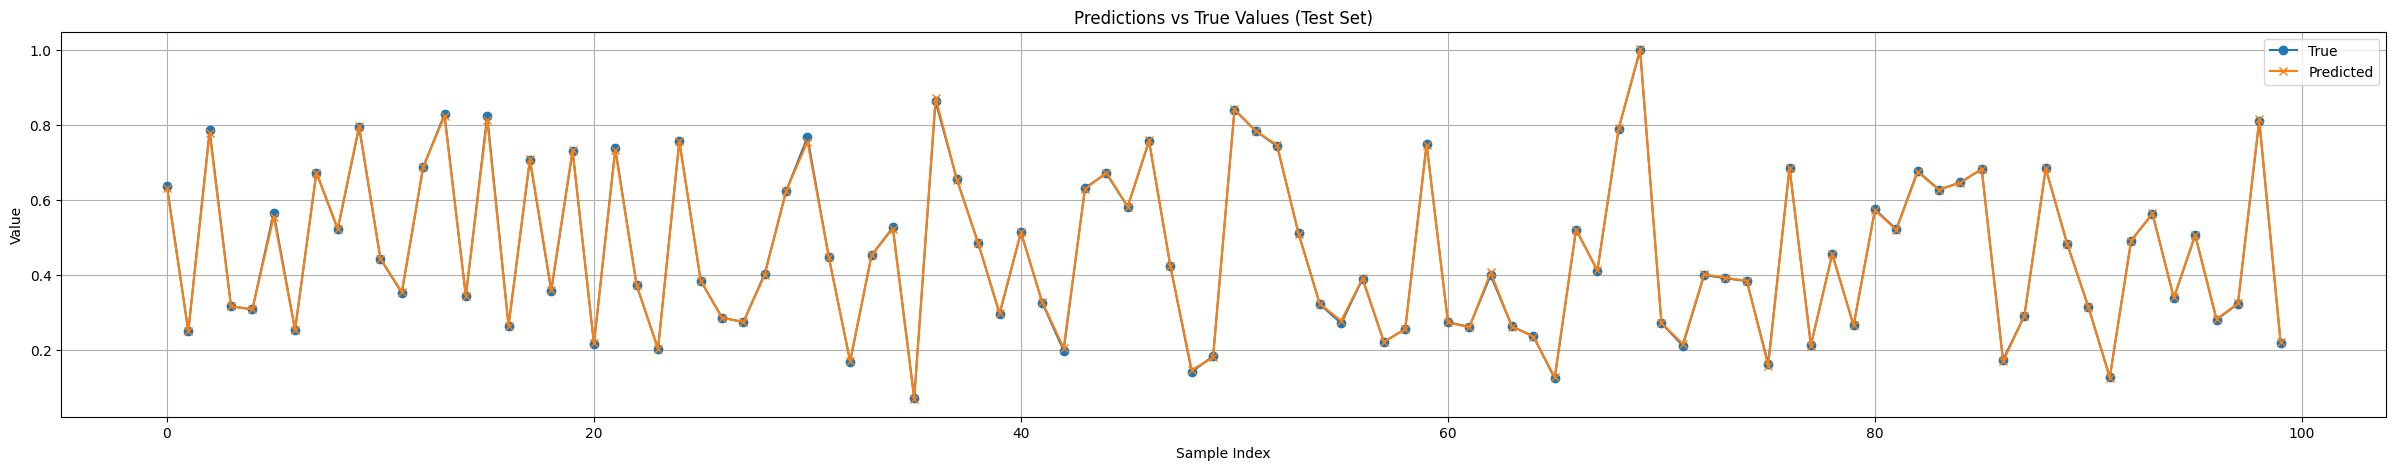

In [26]:
true_values = y_test_t.detach().numpy()
pred_values = pred_test.detach().numpy()

plt.figure(figsize=(30,5))
plt.plot(true_values[0:100], label='True', marker='o')
plt.plot(pred_values[0:100], label='Predicted', marker='x')
plt.title('Predictions vs True Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()